# Implementaremos o Random Forest como solução

Importando as bibliotecas necessárias

In [515]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


Pegando a base de dados de treino

In [516]:
train = pd.read_csv(r"C:\Users\thiag\OneDrive\Desktop\datamining\obesity_risk\data\train.csv")

In [517]:
train.shape

(20758, 18)

Pegando a base de dados de teste

In [518]:
test = pd.read_csv(r"C:\Users\thiag\OneDrive\Desktop\datamining\obesity_risk\data\test.csv")

In [519]:
train.head(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [520]:
test.head(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


Testando se tem dados duplicados

In [521]:
duplicates = train.duplicated()
num_duplicates = duplicates.sum()
print(num_duplicates)

0


In [522]:
duplicates = test.duplicated()
num_duplicates = duplicates.sum()
print(num_duplicates)

0


A coluna id é desnecessária

In [523]:
train = train.drop("id", axis=1)
test_id = test['id']
test = test.drop("id", axis=1)

Testando se tem algum dado vazio

In [524]:
NAs = pd.concat([train.isnull().sum()], axis=1, keys=["Train"])
NAs[NAs.sum(axis=1)>0]

,Train


Nenhum dado vazio

Vendo os tipos de dado de cada coluna

In [525]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

Todos com tipo 'object' tem que ser convertidos

Vendo a quantidade de dados unicos que cada objeto tem

In [526]:
train.nunique()

Gender                               2
Age                               1703
Height                            1833
Weight                            1979
family_history_with_overweight       2
FAVC                                 2
FCVC                               934
NCP                                689
CAEC                                 4
SMOKE                                2
CH2O                              1506
SCC                                  2
FAF                               1360
TUE                               1297
CALC                                 3
MTRANS                               5
NObeyesdad                           7
dtype: int64

In [527]:
test.nunique()

Gender                               2
Age                               1539
Height                            1739
Weight                            1798
family_history_with_overweight       2
FAVC                                 2
FCVC                               828
NCP                                649
CAEC                                 4
SMOKE                                2
CH2O                              1366
SCC                                  2
FAF                               1260
TUE                               1172
CALC                                 4
MTRANS                               5
dtype: int64

Para objetos com mais de 2 dados unicos faremos um dicionario

In [528]:
categorical_columns = train.select_dtypes(include= ['object'])
categorical_columns.columns

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

Esses tem que ser convertidos

In [529]:
train['NObeyesdad'].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

Dicionário com 7 entradas

In [530]:
target = {'Insufficient_Weight' : '0',
          'Normal_Weight' : '1',
          'Overweight_Level_I' : '2',
          'Overweight_Level_II' : '3',
          'Obesity_Type_I' : '4',
          'Obesity_Type_II' : '5',
          'Obesity_Type_III' : '6',
        }

In [531]:
train['NObeyesdad'] = train['NObeyesdad'].replace(target).astype('int64')
train['NObeyesdad'].unique()

array([3, 1, 0, 6, 5, 2, 4], dtype=int64)

Repetir o procedimento acima com as outras colunas

In [532]:
train['MTRANS'].unique()

array(['Public_Transportation', 'Automobile', 'Walking', 'Motorbike',
       'Bike'], dtype=object)

In [533]:
target = {'Walking' : '0',
          'Bike' : '1',
          'Motorbike' : '2',
          'Public_Transportation' : '3',
          'Automobile' : '4',
          }

In [534]:
train['MTRANS'] = train['MTRANS'].replace(target).astype('int64')
train['MTRANS'].unique()

array([3, 4, 0, 2, 1], dtype=int64)

In [535]:
test['MTRANS'] = test['MTRANS'].replace(target).astype('int64')

In [536]:
train['CAEC'].unique()

array(['Sometimes', 'Frequently', 'no', 'Always'], dtype=object)

In [537]:
train['CALC'].unique()

array(['Sometimes', 'no', 'Frequently'], dtype=object)

In [538]:
target = {'no' : '0',
          'Sometimes' : '1',
          'Frequently' : '2',
          'Always' : '3',
          }

In [539]:
train['CAEC'] = train['CAEC'].replace(target).astype('int64')
train['CAEC'].unique()

array([1, 2, 0, 3], dtype=int64)

In [540]:
test['CAEC'] = test['CAEC'].replace(target).astype('int64')

In [541]:
target = {'no' : '0',
          'Sometimes' : '1',
          'Frequently' : '2',
          'Always' : '3',
          }

In [542]:
train['CALC'] = train['CALC'].replace(target).astype('int64')
train['CALC'].unique()

array([1, 0, 2], dtype=int64)

In [543]:
test['CALC'] = test['CALC'].replace(target).astype('int64')
test['CALC'].unique()

array([1, 0, 2, 3], dtype=int64)

In [544]:
train.nunique()

Gender                               2
Age                               1703
Height                            1833
Weight                            1979
family_history_with_overweight       2
FAVC                                 2
FCVC                               934
NCP                                689
CAEC                                 4
SMOKE                                2
CH2O                              1506
SCC                                  2
FAF                               1360
TUE                               1297
CALC                                 3
MTRANS                               5
NObeyesdad                           7
dtype: int64

In [545]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  int64  
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [546]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          13840 non-null  object 
 1   Age                             13840 non-null  float64
 2   Height                          13840 non-null  float64
 3   Weight                          13840 non-null  float64
 4   family_history_with_overweight  13840 non-null  object 
 5   FAVC                            13840 non-null  object 
 6   FCVC                            13840 non-null  float64
 7   NCP                             13840 non-null  float64
 8   CAEC                            13840 non-null  int64  
 9   SMOKE                           13840 non-null  object 
 10  CH2O                            13840 non-null  float64
 11  SCC                             13840 non-null  object 
 12  FAF                             

Restam apenas os com 2 opções, entao usaremos o getdummies

In [547]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [548]:
train.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad', 'Gender_Female', 'Gender_Male',
       'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes', 'SMOKE_no',
       'SMOKE_yes', 'SCC_no', 'SCC_yes'],
      dtype='object')

So precisamos de 1 coluna para cada, logo vamos remover algumas

In [549]:
test.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,...,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes
0,26.899886,1.848294,120.644178,2.938616,3.000000,1,2.825629,0.855400,0.000000,1,...,False,True,False,True,False,True,True,False,True,False
1,21.000000,1.600000,66.000000,2.000000,1.000000,1,3.000000,1.000000,0.000000,1,...,True,False,False,True,False,True,True,False,True,False
2,26.000000,1.643355,111.600553,3.000000,3.000000,1,2.621877,0.000000,0.250502,1,...,True,False,False,True,False,True,True,False,True,False
3,20.979254,1.553127,103.669116,2.000000,2.977909,1,2.786417,0.094851,0.000000,1,...,False,True,False,True,False,True,True,False,True,False
4,26.000000,1.627396,104.835346,3.000000,3.000000,1,2.653531,0.000000,0.741069,1,...,True,False,False,True,False,True,True,False,True,False


In [550]:
train = train.drop(columns=['Gender_Female','family_history_with_overweight_no','FAVC_no','SMOKE_no','SCC_no',])
test = test.drop(columns=['Gender_Female','family_history_with_overweight_no','FAVC_no','SMOKE_no','SCC_no',])

In [551]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 20758 non-null  float64
 1   Height                              20758 non-null  float64
 2   Weight                              20758 non-null  float64
 3   FCVC                                20758 non-null  float64
 4   NCP                                 20758 non-null  float64
 5   CAEC                                20758 non-null  int64  
 6   CH2O                                20758 non-null  float64
 7   FAF                                 20758 non-null  float64
 8   TUE                                 20758 non-null  float64
 9   CALC                                20758 non-null  int64  
 10  MTRANS                              20758 non-null  int64  
 11  NObeyesdad                          20758

In [552]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 13840 non-null  float64
 1   Height                              13840 non-null  float64
 2   Weight                              13840 non-null  float64
 3   FCVC                                13840 non-null  float64
 4   NCP                                 13840 non-null  float64
 5   CAEC                                13840 non-null  int64  
 6   CH2O                                13840 non-null  float64
 7   FAF                                 13840 non-null  float64
 8   TUE                                 13840 non-null  float64
 9   CALC                                13840 non-null  int64  
 10  MTRANS                              13840 non-null  int64  
 11  Gender_Male                         13840

Podemos adcionar uma coluna IMC que pode ser relevante para a classificação

In [553]:
train['imc'] = (train['Weight'])/((train['Height'])**2)

In [554]:
test['imc'] = (test['Weight'])/((test['Height'])**2)

In [555]:
train.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,imc
0,24.443011,1.699998,81.669950,2.000000,2.983297,1,2.763573,0.000000,0.976473,1,3,3,True,True,True,False,False,28.259565
1,18.000000,1.560000,57.000000,2.000000,3.000000,2,2.000000,1.000000,1.000000,0,4,1,False,True,True,False,False,23.422091
2,18.000000,1.711460,50.165754,1.880534,1.411685,1,1.910378,0.866045,1.673584,0,3,0,False,True,True,False,False,17.126706
3,20.952737,1.710730,131.274851,3.000000,3.000000,1,1.674061,1.467863,0.780199,1,3,6,False,True,True,False,False,44.855798
4,31.641081,1.914186,93.798055,2.679664,1.971472,1,1.979848,1.967973,0.931721,1,3,3,True,True,True,False,False,25.599151


Nenhum tipo objeto

Converter tudo pra float

In [556]:
train = train.astype(float)
test = test.astype(float)

Fazer uma matriz de correlação

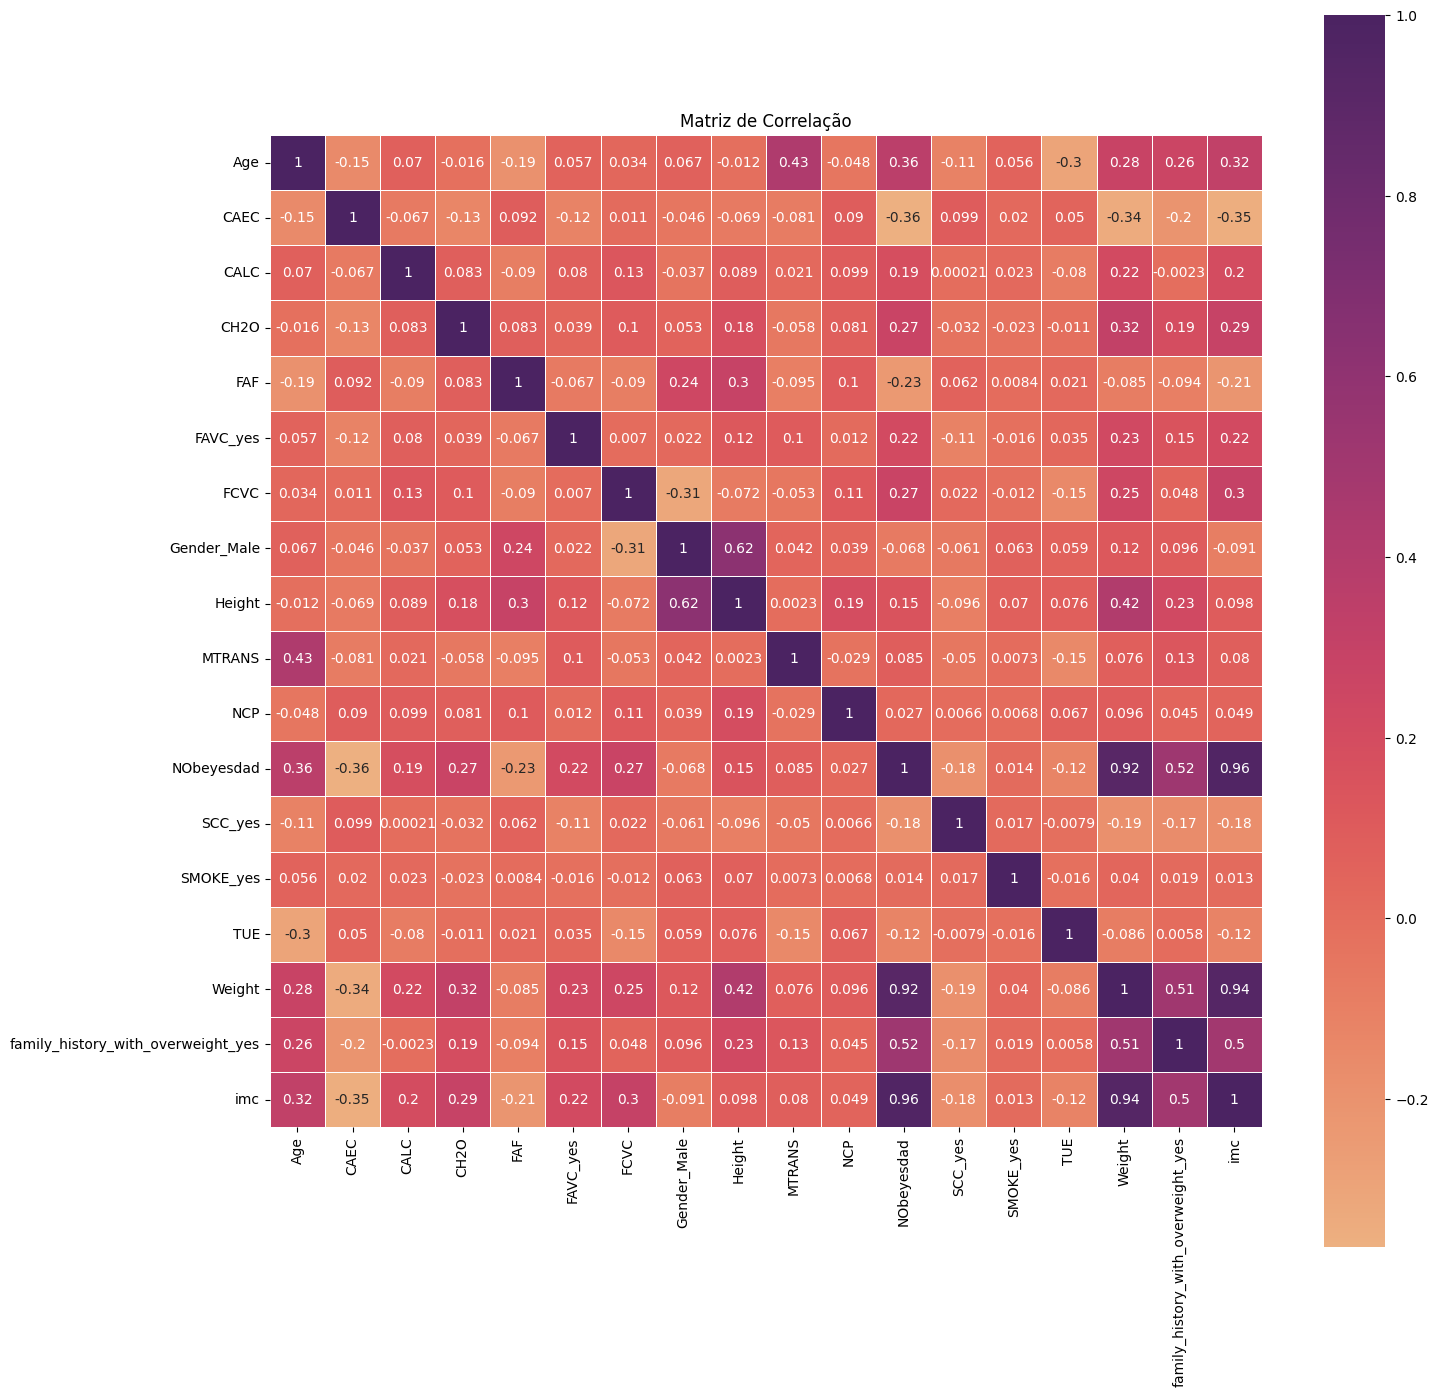

In [557]:
correlation_matrix = train.corr()

sorted_correlation = correlation_matrix['NObeyesdad'].sort_index(ascending=True)

correlated_columns = sorted_correlation.index

subset_correlation_matrix = correlation_matrix.loc[correlated_columns, correlated_columns]

plt.figure(figsize=(16, 16))
sns.heatmap(subset_correlation_matrix, annot=True, cmap='flare', square=True, linewidths= 0.5)
plt.title('Matriz de Correlação')
plt.show()


Reparamos que imc, peso e histórico familiar são os 3 maiores fatores, e que a adição do imc foi valiosa

Vamos treinar nosso modelo agora

Tirando a coluna de obesidade da parte de treino

In [558]:
X = train.drop('NObeyesdad', axis=1)
y = train['NObeyesdad']

Dividindo em treino e validação

In [559]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Importando o RandomForest

In [560]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

In [561]:
model.fit(X_train, y_train)

prediction = model.predict(X_val)

In [562]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(prediction, y_val)
print(accuracy)

0.8973988439306358


Acurácia de 89.9% para o RandomForest, comparado com os 77,4% do NaiveBayes no outro arquivo

Fazendo a matriz de confusão

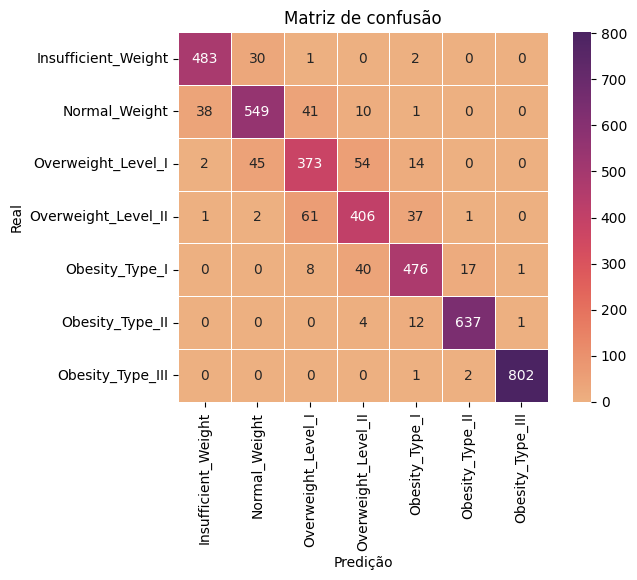

In [563]:
labels = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
confusion = confusion_matrix(prediction, y_val)
sns.heatmap(confusion, annot=True, cmap='flare', square=True, linewidths= 0.5, xticklabels=labels, yticklabels=labels, fmt='g')
plt.title('Matriz de confusão')
plt.ylabel('Real')
plt.xlabel('Predição')
plt.show()

Fazendo o arquivo submission.csv

In [564]:
test_predictions = model.predict(test)
test_predictions

array([5., 2., 6., ..., 0., 1., 5.])

Faremos um dataframe com esse array

In [565]:
test_results = pd.DataFrame({'id': test_id, 'NObeyesdad' : test_predictions})

Invertemos o dicionario criado no inicio

In [566]:
target2 = { 0 : 'Insufficient_Weight',
            1 : 'Normal_Weight', 
            2 : 'Overweight_Level_I',
            3 : 'Overweight_Level_II',
            4 : 'Obesity_Type_I',
            5 : 'Obesity_Type_II',
            6 : 'Obesity_Type_III',
            }

test_results['NObeyesdad'] = test_results['NObeyesdad'].replace(target2)

Transformar em csv

In [567]:
test_results[['id','NObeyesdad']].to_csv('submission.csv', index=False)

No kaggle
Score: 0.89848
Public score: 0.89776